# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import json
from datetime import datetime
from scipy.stats.stats import pearsonr
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head(2)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10


In [3]:
transcript.head(2)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [4]:
profile.head(3)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN


I first need to create the fields needed for analysis.  The first is years a person has been a member in the program. I find the last date somebody became a member and counting the number of years a person is a member from that date

In [5]:
profile['became_member'] = profile['became_member_on'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
profile.head(3)
max_member = max(profile['became_member'])
print(max_member)
profile['member_years_from_20180726'] = (max_member - profile['became_member'])/np.timedelta64(1,'Y')
profile.head(2)

2018-07-26 00:00:00


,age,became_member_on,gender,id,income,became_member,member_years_from_20180726
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017-02-12,1.448353
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,1.029453


The years as a member is skewed towards the right meaning there are a lot more newer members than older ones.

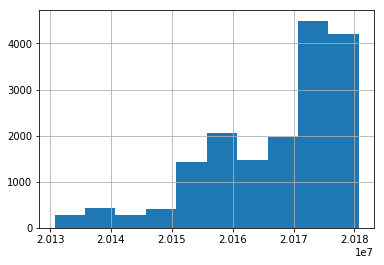

In [6]:
profile['became_member_on'].hist()

The age of 118 correlates well with blanks on gender and income so I'm assuming a 118 represents a missing age. 
Plus, very few people live to 118 which also strenghens my believe it's a placeholder number.  Making blank.

In [7]:
profile.loc[profile['age'] == 118,'age'] = None

Creating some binary variables for use later when determining the % of variables that are missing and/or percentage of records with a certain attribute (such as gender)

In [8]:
profile['no_age'] = np.where(profile['age'].isnull(), 1, 0)
profile['no_income'] = np.where(profile['income'].isnull(), 1, 0)
profile['no_gender'] = np.where(profile['gender'].isnull(), 1, 0)
profile['Female'] = np.where(profile['gender']=='F', 1, 0)
profile.head(2)

,age,became_member_on,gender,id,income,became_member,member_years_from_20180726,no_age,no_income,no_gender,Female
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017-02-12,1.448353,1,1,1,0
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,1.029453,0,0,0,1


Checking means to show that the age of 118 was only on the lines with missing gender/income. 

In [9]:
profile[['no_age','no_gender','no_income']].mean()

no_age       0.127941
no_gender    0.127941
no_income    0.127941
dtype: float64

To the portfolio dataset I'm adding a "duration_hours" field since the times are in hours and the duration is in days.  This will be helpful down the line when trying to compare and making sure that the test and control groups are selected with no overlap in influence from other offers.

In [10]:
portfolio['duration_hours'] = portfolio['duration']*24
portfolio



,channels,difficulty,duration,id,offer_type,reward,duration_hours
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,168
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,120
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,96
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,168
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,240
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,168
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,240
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,72
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,120
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,168


In [11]:
transcript.head(2)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


Identifying times in which offers were sent out.  Still trying to understand the dataset and whether the selection of which member gets an offer at a given time appears to be random.

Offers were sent out at 6 different times with different intervals in between.  Ideally for my A/B testing 
I'll be looking for a control group without an offer/introduction to compare against a test group with the  
offer/introduction.   I'll also need to check and see if there are any visible differences in demographics that shouldn't vary between the test and control (e.g. % female, % with missing values, time as member) If there are large differences in these variables then 


In [12]:
transcript[transcript['event']=='offer received'].groupby('time').size()

time
0      12650
168    12669
336    12711
408    12778
504    12704
576    12765
dtype: int64

Checking out the max transcript time to see how long the period from 576 onward lasts

In [13]:
max(transcript['time'])

714

Here I'm adding a new offer_id field that is more descriptive in nature.

In [14]:
offer_id = []
for index, row in portfolio.iterrows():
    offer_id.append(row['offer_type']+'_dif'+('00'+str(row['difficulty']))[-3:]
                    +'_dur'+('00'+str(row['duration_hours']))[-3:]+'_rew'+('00'+str(row['reward']))[-3:])

portfolio['offer_id'] = offer_id
portfolio

,channels,difficulty,duration,id,offer_type,reward,duration_hours,offer_id
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,168,bogo_dif010_dur168_rew010
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,120,bogo_dif010_dur120_rew010
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,96,informational_dif000_dur096_rew000
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,168,bogo_dif005_dur168_rew005
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,240,discount_dif020_dur240_rew005
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,168,discount_dif007_dur168_rew003
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,240,discount_dif010_dur240_rew002
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,72,informational_dif000_dur072_rew000
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,120,bogo_dif005_dur120_rew005
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,168,discount_dif010_dur168_rew002


Next I ensure there aren't duplicate profiles (so that joining at a later step doesn't create duplicates).  No duplicates found.

In [15]:
len(profile['id'].unique()) == len(profile['id'])

True

The value field in the transcript dataset contains three pieces of information (offer id, amount spent on transactions, and the amount of reward paid out).  The section below breaks those values out into their own separate columns and then merges those columns back into the transcript dataset.

In [16]:
# parsing transcript column into value, amount and offer_id

amount = []
offer_id = []
reward = []
for item in transcript['value']:
    try:
        amount.append(item['amount'])
    except:
        amount.append(0)
    try:
        offer_id.append(item['offer id'])
    except:
        try:
            offer_id.append(item['offer_id'])
        except:
            offer_id.append(None)
    try:
        reward.append(item['reward'])
    except:
        reward.append(0)


transcript['id'] = offer_id
transcript['amount'] = amount
transcript['reward'] = reward
transcript.tail(2)

,event,person,time,value,id,amount,reward
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,{'amount': 3.5300000000000002},None,3.53,0
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,{'amount': 4.05},None,4.05,0


In [17]:
# Adding columns back to the transcript dataset

transcript = transcript.merge(portfolio[['id','offer_id','duration_hours']],how='left',on = 'id')


In [18]:
transcript.head(2)

,event,person,time,value,id,amount,reward,offer_id,duration_hours
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,bogo_dif005_dur168_rew005,168.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,discount_dif020_dur240_rew005,240.0


The test below ensures that nobody received more than one offer during a particular offer delivery period.

In [19]:
number_period_offers = transcript[transcript['event']=='offer received'].groupby(['person','time']).size().reset_index().sort_values(0, ascending=False)
number_period_offers.head(2)

,person,time,0
0,0009655768c64bdeb2e877511632db8f,168,1
50858,a93b655903f249c7bc074c0b4b69f52e,168,1


The A/B testing that I plan on performing will look at a group of customers who have an offer for a time period and compare them against a control group without an offer during the same time period.  The time period will be the length of duration that the particular offer is impressionable for.  For example, the bogo_dif010_dur168_rew010 offer has an impression length of 168 hours.  Therefore, I'll be testing a group that has this offer vs a group without and compare the average revenue per person in the control group over the 168 hours vs that of the offer group during that same 168 hours.  The offer group will have any rewards paid out subtracted from the revenue values to ensure that a positive statistical result (obtained through bootstrapping) shows that the offer brings in additional revenue after taking into account any reward revenue paid out to customers.

In some cases, the offers overlap time periods. for example, if at time 0 a person got an offer that had an impression time of 240 hours, then the offer would still be impressing on a person at time 168 when they might be getting a second offer.  Therefore, I'll have to remove any customers who overlap in offers.  I'll do this farther down in the code but wanted to call out here.

In [20]:
def period_spend(coupons_at = [0, 168, 336, 408, 504, 576], hour_duration = 72):
    """
    Determines the amount of revenue a customer generates for Starbucks during a given amount of time
    (hour duration).  The spend is calculated starting from the different times where offers are received
    (time=0, 168, 336, etc.) so that any of the groups could be used for our tests later on.  
    
    Input parameters:
        coupons_at: specifies the time values at which offers/informationals were distributed
        
        hour duration: the number of hours from the coupons_at time that revenue is to be calculated. (Note
        that revenue is calculated as the amount of spend a person has minus any rewards Starbucks pays out for
        fulfilling a coupon/offer during that same time period)
    
    Output value:
        df:  DataFrame with the following additional columns:
            revenue during a given time period (based on hour_duration)
            start_time for when duration starts
            total hours of the spend duration
    """
    for time in coupons_at:
        end_time = time + hour_duration - 1
        time_zero_spend = transcript[['person','time','amount','reward']].loc[(transcript['time'] >= time) & (transcript['time'] <= end_time), ]
        time_zero_spend = time_zero_spend[['person','amount','reward']].groupby(['person']).sum()
        time_zero_spend['revenue'] = time_zero_spend['amount']-time_zero_spend['reward']
        time_zero_spend['start_time'] = time
        time_zero_spend['duration_hours'] = hour_duration
        
        if time == coupons_at[0]:
            df = time_zero_spend
        else:
            df = pd.concat([df, time_zero_spend])
    
    return df

In [21]:
def joined_dfs(durations = [72,96,120,168,240]):
    """
    Builds off of the period_spend function.  This loops through and for all hour_durations (which were derived from
    each unique number of hours the offers are impressionable for) it calculates the spend for a given start time/time duration. 
    
    Input parameters:
        durations:  list of hour durations you'd like to calculate spend over
    
    Output value:
        df2:  concatenated dataframe with all duration/spend start time duration combinations.  
    """
    for period in durations:
        df = period_spend(coupons_at = [0, 168, 336, 408, 504, 576], hour_duration = period)
        if period == durations[0]:
            df2 = df
        else:
            df2 = pd.concat([df2, df])
    return df2
    


In [22]:
overall = joined_dfs(durations = [72,96,120,168,240]).reset_index()

I'm providing an example below to confirm my matching worked.  I show one person and their spend during the first 240 hours.
At 72 hours (hours 0 to 71), they've spent a total of 49.63 (17.63 + 32).  However, they also redeemed a 2-dollar reward
during the time making their total revenue for that period \$47.63 after subtracting the 2 dollar reward.  

At a time duration of 96 hours, the additional 24.39 in spend at time = 72 is also included to make total spend
72.02. At 168 hours (time = 0 to time = 167) the additional 24.31 is included for a total revenue during the period
of 96.33.

In [23]:
#Providing example of one individual.

transcript.drop(['value','id'], axis=1).loc[(transcript['person'] == '5ffdab087e674149a89324a732b4f993') 
              & (transcript['time'] <= 240)]

,event,person,time,amount,reward,offer_id,duration_hours
42098,transaction,5ffdab087e674149a89324a732b4f993,102,1.90,0,NaN,NaN
54047,offer received,5ffdab087e674149a89324a732b4f993,168,0.00,0,informational_dif000_dur072_rew000,72.0
77361,offer viewed,5ffdab087e674149a89324a732b4f993,192,0.00,0,informational_dif000_dur072_rew000,72.0
87277,transaction,5ffdab087e674149a89324a732b4f993,222,3.87,0,NaN,NaN


In [24]:
overall.loc[(overall['person']=='0020c2b971eb4e9188eac86d93036a77') & (overall['start_time']==0)]

,person,amount,reward,revenue,start_time,duration_hours
1,0020c2b971eb4e9188eac86d93036a77,49.63,2,47.63,0,72
87793,0020c2b971eb4e9188eac86d93036a77,74.02,2,72.02,0,96
180649,0020c2b971eb4e9188eac86d93036a77,74.02,2,72.02,0,120
275756,0020c2b971eb4e9188eac86d93036a77,98.33,2,96.33,0,168
372424,0020c2b971eb4e9188eac86d93036a77,98.33,2,96.33,0,240


As mentioned earlier, the A/B testing I plan on using requires a control group without an active offer/informational 
and a test group with only one offer at the time.  Because of the way the coupons were sent out, some tests will need
to know what a person had in the next offer handout session to get the right group for testing.  For example, if I use the 
time=0 group to test the discount_dif10_dur240_rew2 offer (which lasts for 240 hours) I would need to find those at 
time = 0 given no offer who ALSO didn't receive an offer at time = 168 (control group) and then compare those with people who
got an offer of discount_dif10_dur240_rew2 at time = 0 and ALSO didn't get an offer at time = 168 (test group).  This is because the 
offer tested here is impressionable for 240 hours.  To avoid cross contamination of people getting a different offer at
time = 168 I need to know that the person had no offer at time = 168.  To do this, I create a table to add for lookup
purposes that would give me the offer the person will receive at the next time and also the offer they received last time.

In [25]:
current = [0, 168, 336, 408, 504, 576]
last = [None, 0, 168, 336, 408, 504]
next = [168, 336, 408, 504, 576, None]
of_dict = {'last_offertime':last, 'time':current, 'next_offertime':next}

offertimes = pd.DataFrame(of_dict)
offertimes

,last_offertime,time,next_offertime
0,NaN,0,168.0
1,0.0,168,336.0
2,168.0,336,408.0
3,336.0,408,504.0
4,408.0,504,576.0
5,504.0,576,NaN


In [26]:
offers_received = transcript[transcript['event']=='offer received'].copy()
offers_received['offer_duration_hours'] = offers_received['duration_hours']
offers_received = pd.merge(offers_received, offertimes, how = 'left', on = 'time')

offers_received.drop(['value', 'id','time', 'amount', 'reward'], axis=1).head()

,event,person,offer_id,duration_hours,offer_duration_hours,last_offertime,next_offertime
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,bogo_dif005_dur168_rew005,168.0,168.0,NaN,168.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,discount_dif020_dur240_rew005,240.0,240.0,NaN,168.0
2,offer received,e2127556f4f64592b11af22de27a7932,discount_dif010_dur168_rew002,168.0,168.0,NaN,168.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,discount_dif010_dur240_rew002,240.0,240.0,NaN,168.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,bogo_dif010_dur120_rew010,120.0,120.0,NaN,168.0


Now I need to take the important data and combine it all into a master dataset that will be used for my A/B testing.

In [27]:
# First step is to create a cartesian plot that includes all individuals at all times and all durations

times = []
durations = []
persons = []
for time in [0,168,336,408,504,576]:
    for duration in [72,96,120,168,240]:
        for person in profile['id']:
            times.append(time)
            durations.append(duration)
            persons.append(person)

start_dur_dict = {'start_time':times, 'duration_hours':durations, 'person':persons}
times_durations = pd.DataFrame(start_dur_dict)

# next I merge the overall df from earlier that has summary spend for each individual with spend across the time and durations
times_durations = times_durations.merge(overall, how = 'left', on = ['start_time','duration_hours','person'] ).fillna(0)



times_durations = times_durations.merge(offers_received[['time','offer_id','offer_duration_hours','person']], how= 'left', 
                      left_on = ['start_time','person'], right_on = ['time','person'])

times_durations = times_durations.drop('time', axis=1)

#The blank values represent individuals who weren't on the transcript file because they didn't get an offer during a period.  
#I replace the null offer_id values with 'no_offer' to indicate there was no offer.  This group will be used for my control.

times_durations['offer_id'] = times_durations['offer_id'].fillna('no_offer')

times_durations.head().reset_index()





,index,start_time,duration_hours,person,amount,reward,revenue,offer_id,offer_duration_hours
0,0,0,72,68be06ca386d4c31939f3a4f0e3dd783,0.00,0.0,0.00,no_offer,NaN
1,1,0,72,0610b486422d4921ae7d2bf64640c50b,21.51,0.0,21.51,no_offer,NaN
2,2,0,72,38fe809add3b4fcf9315a9694bb96ff5,0.00,0.0,0.00,no_offer,NaN
3,3,0,72,78afa995795e4d85b5d9ceeca43f5fef,0.00,0.0,0.00,bogo_dif005_dur168_rew005,168.0
4,4,0,72,a03223e636434f42ac4c3df47e8bac43,0.00,0.0,0.00,discount_dif020_dur240_rew005,240.0


This test that the number of rows in times_durations is what I would expect if I had one row for every 
person/time_duration/offer_start time combination.  It matches so I'm set!

In [28]:
len(profile['id'])*len([72,96,120,168,240])*len([0, 168, 336, 408, 504, 576])  == len(times_durations['person'])

True

Since all offer_id/time combinations are available in the times_durations dataframe for each person for all time_durations, 
I only need look at one time_duration to get time/offer combos for a person.  So, in the code below I arbitrarily choose duration_hours of 72.  I am tacking on the next_offer_id as previously discussed so that I can remove people with an offer at the next offer time in cases where I need to test something for a time period that is longer than the time period being tested.

In [29]:
offers_list = times_durations.loc[(times_durations['duration_hours'] == 72),['person','offer_id','start_time']]
offers_list.columns = ['person', 'offer_id', 'time']
offers_list = pd.merge(offers_list, offertimes, how = 'left', on = 'time')
offers_list.head()

,person,offer_id,time,last_offertime,next_offertime
0,68be06ca386d4c31939f3a4f0e3dd783,no_offer,0,NaN,168.0
1,0610b486422d4921ae7d2bf64640c50b,no_offer,0,NaN,168.0
2,38fe809add3b4fcf9315a9694bb96ff5,no_offer,0,NaN,168.0
3,78afa995795e4d85b5d9ceeca43f5fef,bogo_dif005_dur168_rew005,0,NaN,168.0
4,a03223e636434f42ac4c3df47e8bac43,discount_dif020_dur240_rew005,0,NaN,168.0


In [30]:
nextoffer = offers_list[['person', 'offer_id', 'time']]
nextoffer.columns = ['person','next_offer_id','next_offertime']
nextoffer.head()

lastoffer = offers_list[['person', 'offer_id', 'time']]
lastoffer.columns = ['person','last_offer_id','last_offertime']



offers_list = pd.merge(offers_list, lastoffer, how = 'left', on = ['person', 'last_offertime'])
offers_list = pd.merge(offers_list, nextoffer, how = 'left', on = ['person', 'next_offertime'])
offers_list.columns = ['person', 'offer_id', 'start_time', 'last_offertime', 'next_offertime', 'last_offer_id', 'next_offer_id']



Pulling up table on one person to verify that the next_offer_id field populated correctly.  Looks good!  The last offer and next offer match what the data says the person got.

In [31]:
offers_list[offers_list['person'] == '68be06ca386d4c31939f3a4f0e3dd783']

,person,offer_id,start_time,last_offertime,next_offertime,last_offer_id,next_offer_id
0,68be06ca386d4c31939f3a4f0e3dd783,no_offer,0,NaN,168.0,NaN,discount_dif010_dur168_rew002
17000,68be06ca386d4c31939f3a4f0e3dd783,discount_dif010_dur168_rew002,168,0.0,336.0,no_offer,discount_dif020_dur240_rew005
34000,68be06ca386d4c31939f3a4f0e3dd783,discount_dif020_dur240_rew005,336,168.0,408.0,discount_dif010_dur168_rew002,discount_dif010_dur240_rew002
51000,68be06ca386d4c31939f3a4f0e3dd783,discount_dif010_dur240_rew002,408,336.0,504.0,discount_dif020_dur240_rew005,discount_dif007_dur168_rew003
68000,68be06ca386d4c31939f3a4f0e3dd783,discount_dif007_dur168_rew003,504,408.0,576.0,discount_dif010_dur240_rew002,discount_dif010_dur240_rew002
85000,68be06ca386d4c31939f3a4f0e3dd783,discount_dif010_dur240_rew002,576,504.0,NaN,discount_dif007_dur168_rew003,NaN


I'm adding dummy variables to indicate which offer a person got.  This will be helpful to see if the percentage getting an offer in a particular time frame varies across the different time periods where offers are being sent out.  I will want to test and just see if any offer seems to be weighted during a period. Ideally, the tests were set up with random sampling in mind and approximately the same percentage get an offer during each period.  I'll need to also do something similar with demographic variables (% female, % with missing age values, years as a member) to make sure there aren't differences in those for the offers as well.

In [32]:
offer_dummies = pd.get_dummies(times_durations['offer_id'], dtype=int)

In [33]:
times_durations = pd.merge(times_durations, offer_dummies, left_index=True, right_index=True)
times_durations.head()

,start_time,duration_hours,person,amount,reward,revenue,offer_id,offer_duration_hours,bogo_dif005_dur120_rew005,bogo_dif005_dur168_rew005,bogo_dif010_dur120_rew010,bogo_dif010_dur168_rew010,discount_dif007_dur168_rew003,discount_dif010_dur168_rew002,discount_dif010_dur240_rew002,discount_dif020_dur240_rew005,informational_dif000_dur072_rew000,informational_dif000_dur096_rew000,no_offer
0,0,72,68be06ca386d4c31939f3a4f0e3dd783,0.00,0.0,0.00,no_offer,NaN,0,0,0,0,0,0,0,0,0,0,1
1,0,72,0610b486422d4921ae7d2bf64640c50b,21.51,0.0,21.51,no_offer,NaN,0,0,0,0,0,0,0,0,0,0,1
2,0,72,38fe809add3b4fcf9315a9694bb96ff5,0.00,0.0,0.00,no_offer,NaN,0,0,0,0,0,0,0,0,0,0,1
3,0,72,78afa995795e4d85b5d9ceeca43f5fef,0.00,0.0,0.00,bogo_dif005_dur168_rew005,168.0,0,1,0,0,0,0,0,0,0,0,0
4,0,72,a03223e636434f42ac4c3df47e8bac43,0.00,0.0,0.00,discount_dif020_dur240_rew005,240.0,0,0,0,0,0,0,0,1,0,0,0


Adding profile variables to the master dataset to work with

In [34]:
times_durations = pd.merge(times_durations, profile, how='left', left_on = 'person', right_on = 'id')

In [35]:
times_durations = pd.merge(times_durations, offers_list[['person','start_time', 'last_offer_id', 'next_offer_id']],
                                                        how='left', on = ['person','start_time' ])

In [36]:
times_durations.head()

,start_time,duration_hours,person,amount,reward,revenue,offer_id,offer_duration_hours,bogo_dif005_dur120_rew005,bogo_dif005_dur168_rew005,...,id,income,became_member,member_years_from_20180726,no_age,no_income,no_gender,Female,last_offer_id,next_offer_id
0,0,72,68be06ca386d4c31939f3a4f0e3dd783,0.00,0.0,0.00,no_offer,NaN,0,0,...,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017-02-12,1.448353,1,1,1,0,NaN,discount_dif010_dur168_rew002
1,0,72,0610b486422d4921ae7d2bf64640c50b,21.51,0.0,21.51,no_offer,NaN,0,0,...,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,1.029453,0,0,0,1,NaN,no_offer
2,0,72,38fe809add3b4fcf9315a9694bb96ff5,0.00,0.0,0.00,no_offer,NaN,0,0,...,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018-07-12,0.038331,1,1,1,0,NaN,bogo_dif005_dur168_rew005
3,0,72,78afa995795e4d85b5d9ceeca43f5fef,0.00,0.0,0.00,bogo_dif005_dur168_rew005,168.0,0,1,...,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,1.212893,0,0,0,1,NaN,informational_dif000_dur072_rew000
4,0,72,a03223e636434f42ac4c3df47e8bac43,0.00,0.0,0.00,discount_dif020_dur240_rew005,240.0,0,0,...,a03223e636434f42ac4c3df47e8bac43,NaN,2017-08-04,0.974695,1,1,1,0,NaN,no_offer


In [37]:
times_durations.columns

Index(['start_time', 'duration_hours', 'person', 'amount', 'reward', 'revenue',
       'offer_id', 'offer_duration_hours', 'bogo_dif005_dur120_rew005',
       'bogo_dif005_dur168_rew005', 'bogo_dif010_dur120_rew010',
       'bogo_dif010_dur168_rew010', 'discount_dif007_dur168_rew003',
       'discount_dif010_dur168_rew002', 'discount_dif010_dur240_rew002',
       'discount_dif020_dur240_rew005', 'informational_dif000_dur072_rew000',
       'informational_dif000_dur096_rew000', 'no_offer', 'age',
       'became_member_on', 'gender', 'id', 'income', 'became_member',
       'member_years_from_20180726', 'no_age', 'no_income', 'no_gender',
       'Female', 'last_offer_id', 'next_offer_id'],
      dtype='object')

I get the percentage of customers who recieve a particular offer at a given start time below. As you can see by the proportions, it looks like each time period around 7.5% of the customers are given a particular offer (out of 10 offers in total).  That leaves 25% not receiving an offer in any particular time period.  This helps me feel better that there aren't nuances around the different time periods.

This means that I can use any of the time periods to test for A/B results.  In my case, I plan on using times 0 and 168 to conduct all of my testing.  This is to control for variability across time and also is done for simplicity since later time periods would require suppressing multiple offers to get a clean read on the 240 hour duration offers (since their times between offers is shorter than 168 unlike the time=0 and time=168 to their next offer duration)

In [38]:
# https://www.pythontutorial.net/python-basics/python-filter-list/
# This code shows the number of hours between when an offer is given and when the next offer is given.  
# Note that the first two offer time periods of 0 an 168 are the longest and will be used for A/B Testing.

first = pd.Series([0,168,336,408,504,576])
next = pd.Series([168,336,408,504,576,714])
test = next - first
test

0    168
1    168
2     72
3     96
4     72
5    138
dtype: int64

In [39]:
Averages1 = times_durations.loc[times_durations['duration_hours'] == 72][[
       'start_time', 'bogo_dif005_dur120_rew005',
       'bogo_dif005_dur168_rew005', 'bogo_dif010_dur120_rew010',
       'bogo_dif010_dur168_rew010', 'discount_dif007_dur168_rew003',
       'discount_dif010_dur168_rew002', 'discount_dif010_dur240_rew002',
       'discount_dif020_dur240_rew005', 'informational_dif000_dur072_rew000',
       'informational_dif000_dur096_rew000', 'no_offer', 'age', 
      'member_years_from_20180726',
       'no_age', 'no_income', 'no_gender', 'Female'
]].groupby(['start_time']).mean()

Averages1

,bogo_dif005_dur120_rew005,bogo_dif005_dur168_rew005,bogo_dif010_dur120_rew010,bogo_dif010_dur168_rew010,discount_dif007_dur168_rew003,discount_dif010_dur168_rew002,discount_dif010_dur240_rew002,discount_dif020_dur240_rew005,informational_dif000_dur072_rew000,informational_dif000_dur096_rew000,no_offer,age,member_years_from_20180726,no_age,no_income,no_gender,Female
start_time,,,,,,,,,,,,,,,,,
0,0.074294,0.073235,0.071647,0.076000,0.071824,0.073941,0.077529,0.076294,0.074471,0.074882,0.255882,54.393524,1.41673,0.127941,0.127941,0.127941,0.360529
168,0.074294,0.076235,0.072941,0.077588,0.073529,0.074706,0.073529,0.073235,0.074706,0.074471,0.254765,54.393524,1.41673,0.127941,0.127941,0.127941,0.360529
336,0.073353,0.075000,0.075294,0.073235,0.076529,0.074294,0.073118,0.077765,0.073882,0.075235,0.252294,54.393524,1.41673,0.127941,0.127941,0.127941,0.360529
408,0.073529,0.074941,0.076941,0.075176,0.074941,0.078529,0.071882,0.074647,0.076059,0.075000,0.248353,54.393524,1.41673,0.127941,0.127941,0.127941,0.360529
504,0.076765,0.074176,0.077059,0.073412,0.075647,0.075647,0.075471,0.074000,0.072824,0.072294,0.252706,54.393524,1.41673,0.127941,0.127941,0.127941,0.360529
576,0.073118,0.078000,0.072765,0.075059,0.077294,0.071824,0.075353,0.075118,0.076176,0.076176,0.249118,54.393524,1.41673,0.127941,0.127941,0.127941,0.360529


I also look into the variables not expected to vary by time period or offer.  I plot the histograms below for the start time/offer id combinations (66 in total) to see if there are any large outliers.  I'm pleased to say that the distributions for the different time/offer id combinations aren't highly variable suggesting that the offers being given out weren't being influenced by gender, years as a member, time, or income.  

In [40]:
Averages2 = times_durations.loc[times_durations['duration_hours'] == 72][[
       'start_time', 'offer_id', 'age', 'income',
      'member_years_from_20180726',
       'no_age', 'no_income', 'no_gender', 'Female'
]].groupby(['start_time', 'offer_id']).mean()

Averages2.describe()



,age,income,member_years_from_20180726,no_age,no_income,no_gender,Female
count,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000
mean,54.376024,65384.620594,1.416083,0.128094,0.128094,0.128094,0.360161
std,0.398574,491.463530,0.025988,0.007998,0.007998,0.007998,0.012237
min,53.538596,64343.283582,1.341905,0.110851,0.110851,0.110851,0.323730
25%,54.168733,65124.156143,1.403012,0.123026,0.123026,0.123026,0.354918
50%,54.382678,65390.445038,1.420115,0.126804,0.126804,0.126804,0.360518
75%,54.577383,65647.625053,1.435200,0.133184,0.133184,0.133184,0.367494
max,55.299548,66667.584940,1.462656,0.151376,0.151376,0.151376,0.392000


I provide additioinal views of histograms below to show distributions visually.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff60d027d68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7ff60d02a208>]], dtype=object)

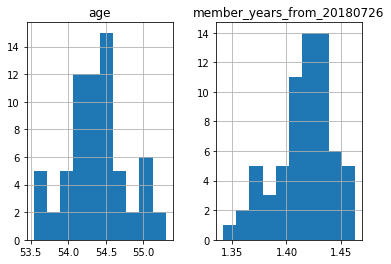

In [41]:
Averages2[['age','member_years_from_20180726']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff60d0486d8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7ff60cfac588>]], dtype=object)

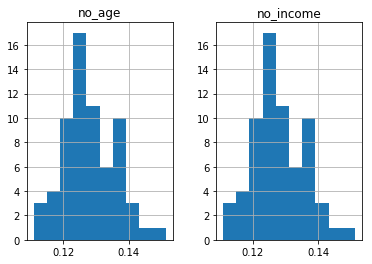

In [42]:
Averages2[['no_age', 'no_income']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff60cfaf518>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7ff60cf9c358>]], dtype=object)

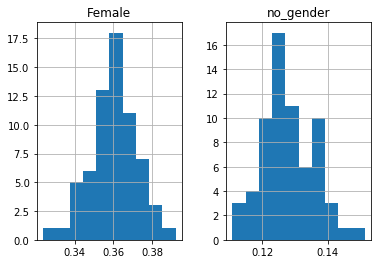

In [43]:
Averages2[['no_gender', 'Female']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff60cf2cb38>]], dtype=object)

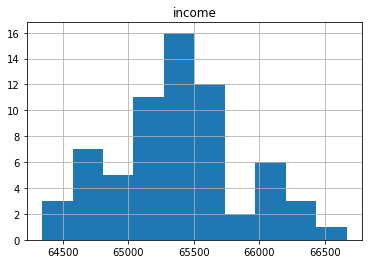

In [44]:
Averages2[['income']].hist()

As one additional test, I plot histograms for the member_years_from_20180726 and income columns to see if the overlap is similar across a few of the different offers.  Sure enough!  The high degree of overlap seen below helps support that the offers sent out at the different time points were random and can be used for A/B testing.

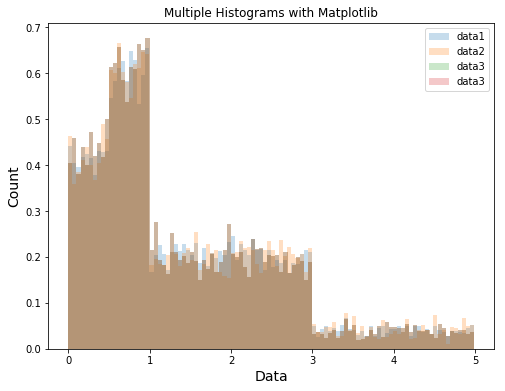

In [45]:
data1 = times_durations.loc[ (times_durations['duration_hours']==72)
                           & (times_durations['offer_id']=='no_offer')]['member_years_from_20180726']
data2 = times_durations.loc[ (times_durations['duration_hours']==72)
                           & (times_durations['offer_id']=='bogo_dif005_dur168_rew005')]['member_years_from_20180726']
data3 = times_durations.loc[ (times_durations['duration_hours']==72)
                           & (times_durations['offer_id']=='discount_dif020_dur240_rew005')]['member_years_from_20180726']
data3 = times_durations.loc[ (times_durations['duration_hours']==72)
                           & (times_durations['offer_id']=='discount_dif007_dur168_rew003')]['member_years_from_20180726']

# https://datavizpyr.com/overlapping-histograms-with-matplotlib-in-python/


plt.figure(figsize=(8,6))
plt.hist(data1, bins=100, alpha=0.25, label="data1", density=True)
plt.hist(data2, bins=100, alpha=0.25, label="data2", density = True)
plt.hist(data3, bins=100, alpha=0.25, label="data3", density = True)
plt.hist(data3, bins=100, alpha=0.25, label="data3", density = True)

plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Multiple Histograms with Matplotlib")
plt.legend(loc='upper right')
plt.savefig("overlapping_histograms_with_matplotlib_Python_2.png")


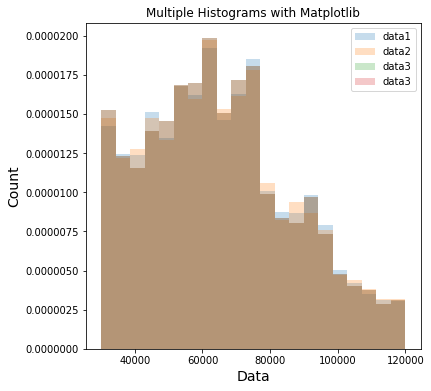

In [46]:
data1 = times_durations.loc[ (times_durations['duration_hours']==72)
                           & (times_durations['offer_id']=='no_offer')]['income'].dropna()
data2 = times_durations.loc[ (times_durations['duration_hours']==72)
                           & (times_durations['offer_id']=='discount_dif010_dur240_rew002')]['income'].dropna()
data3 = times_durations.loc[ (times_durations['duration_hours']==72)
                           & (times_durations['offer_id']=='informational_dif000_dur072_rew000')]['income'].dropna()
data3 = times_durations.loc[ (times_durations['duration_hours']==72)
                           & (times_durations['offer_id']=='informational_dif000_dur096_rew000')]['income'].dropna()

# https://datavizpyr.com/overlapping-histograms-with-matplotlib-in-python/


        
plt.figure(figsize=(6,6))
plt.hist(data1, bins=21, alpha=0.25, label="data1", density=True)
plt.hist(data2, bins=21, alpha=0.25, label="data2", density = True)
plt.hist(data3, bins=21, alpha=0.25, label="data3", density = True)
plt.hist(data3, bins=21, alpha=0.25, label="data3", density = True)

plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Multiple Histograms with Matplotlib")
plt.legend(loc='upper right')
plt.savefig("overlapping_histograms_with_matplotlib_Python_2.png")


Below I set up the bootstrap function which will be used to test to see if the offers make any difference in increasing revenue over doing nothing.  The starting code came from previous Udacity lessons.  Since I'm using time=0 and time=168 I'm choosing to do stratified sampling so that I sample the distributions at each time period separately.

The test and control stratified samples for an offer and for a group without offers is then converted into an average revenue spend per hour for each group.  The test and control differences are then subtracted from eachother.  This process is iterated over again the number of times indicated in the n_trials variable.

In [47]:
def mean_diff_bootstrap(test, control, duration = 168, c = .95, n_trials = 1000, min_sought = 0):
    """
    Uses a bootstrapping sampling technique to determine the difference in average spend per hour in a control group 
    (i.e. group without an offer) vs a test group (i.e. group with an offer) 
    
    Input parameters:
        test: test data in form of 2-column dataframe.  One column 'start_time' would be the time the offer
        was given out.  The other ('revenue') should indicate the amount of revenue for the period.
        duration:  the lengt of time an offer is impressionable for and matches the amount of time the 
        revenue has been calculated over.
        c: confidence interval width
        n_trials: number of bootstrap samples to perform
        min_sought:  The minimum difference you're interested in seeing a percentile for (usually 0).
        This variable was added so that a calculation of the percentage of bootstrapping runs that are less
        than this value gets returned.
    
    Output value:
        lower_limit: the lower difference value in the confidence interval provided in input parameter c
        med_rev: the median revenue difference between test/control values for the bootstrapped samples.
        upper_limit: the upper difference value in the confidence interval provided in input parameter c
        pct_le_zero: percent of differences that are below the amount indicated in min_sought.  Since
        min_sought is usually 0, the variable was called pct_le_zero
        std_dev:  standard deviation of the revenue differences between test/control values for boostrapped samples.
        mean_val: the mean revenue difference between test/control values for the bootstrapped samples.
        n_sample:  The number of boostrapped samples that were collected.

    """
    
    # initialize storage of bootstrapped sample quantiles
    n_points_test0 = test[test['start_time']==0].shape[0]
    n_points_test168 = test[test['start_time']==168].shape[0]
    n_points_control0 = control[control['start_time']==0].shape[0]
    n_points_control168 = control[control['start_time']==0].shape[0]
    
    mean_diff = []
    # For each trial...
    test0 = test[test['start_time']==0]['revenue']
    control0 = control[control['start_time']==0]['revenue']
    test168 = test[test['start_time']==168]['revenue']
    control168 = control[control['start_time']==168]['revenue']
    
    for num in range(n_trials):
        # draw a random sample from the data with replacement...
        sample_test0 = list(np.random.choice(test0, n_points_test0, replace = True))
        sample_test168 = list(np.random.choice(test168, n_points_test168, replace = True))
        test = pd.Series(sample_test0 + sample_test168)

        sample_control0 = list(np.random.choice(control0, n_points_control0, replace = True))
        sample_control168 = list(np.random.choice(control168, n_points_control168, replace = True))
        control = pd.Series(sample_control0 + sample_control168)

        
        # get the mean difference between the two...
        md = test.mean()/duration - control.mean()/duration
 
        
        
        
        # and add the value to the list of sampled quantiles
        mean_diff.append(md)
        
    # Compute the confidence interval bounds
#     ave_rev = sum(mean_diff)/len(mean_diff)
    med_rev = np.percentile(mean_diff, 50)
    lower_limit = np.percentile(mean_diff, (1 - c)/2 * 100)
    upper_limit = np.percentile(mean_diff, (1 + c)/2 * 100)
    std_dev = pd.Series(mean_diff).std()
    mean_val = pd.Series(mean_diff).mean()
    # https://www.pythontutorial.net/python-basics/python-filter-list/ to learn this
    pct_le_zero = len(list(filter(lambda diff: diff <= min_sought, mean_diff)))/len(mean_diff)
    n_sample = len(mean_diff)
    
#     plt.figure(figsize=(6,6))
#     plt.hist(test_data, alpha=0.25, label="test", density=True)
#     plt.hist(control_data, alpha=0.25, label="control", density = True)
#     plt.hist(mean_diff, density = True)

#     plt.xlabel("Revenue Per Person Per Hour", size=14)
#     plt.ylabel("Frequency", size=14)
#     plt.title("Difference In Means Histogram")
#     plt.legend(loc='upper right')
#     plt.savefig("overlapping_histograms_with_matplotlib_Python_2.png")
    
    return (lower_limit, med_rev,  upper_limit, pct_le_zero, std_dev, mean_val, n_sample)

The section below uses the bootstrapping function from above and runs through all different offers to get their differences between a test and control group.  It then combines them all into a dataframe so that the values can be compared across offers.

The code is more complex due to the different filtering that has to be done at the different time points based upon the impression duration being tested.  For example, at time=0 there is no previous offer that could be impressioning upon customers.  However, at time=168 there is so any customers who received an offer that was more than 168 hours in impression time would need to be removed from the test/control data points as it has a confounding effect.

In [48]:
# https://www.geeksforgeeks.org/create-a-pandas-dataframe-from-lists/
starts = []
offers = []
ll = []
med = []
ul = []
pct_le_zero = []
sd = []
mn = []
n_s = []

for offer_val in ['bogo_dif005_dur168_rew005',
 'discount_dif020_dur240_rew005',
 'discount_dif010_dur168_rew002',
 'discount_dif010_dur240_rew002',
 'bogo_dif010_dur120_rew010',
 'bogo_dif005_dur120_rew005',
 'discount_dif007_dur168_rew003',
 'informational_dif000_dur096_rew000',
 'bogo_dif010_dur168_rew010',
 'informational_dif000_dur072_rew000']:


    difficulty = int(offer_val[-17:-14])
    duration = int(offer_val[-10:-7])
    reward = int(offer_val[-3:])
    times_durations[['start_time','duration_hours','person','revenue','last_offer_id','offer_id','next_offer_id']]

    if duration < 240:

        test0 = times_durations.loc[(times_durations['start_time'] == 0) 
                                & (times_durations['offer_id']== offer_val)
                                & (times_durations['duration_hours']==duration)][['revenue','start_time']]

        control0 = times_durations.loc[(times_durations['start_time'] == 0) 
                                & (times_durations['offer_id']== 'no_offer')
                                & (times_durations['duration_hours']==duration)][['revenue','start_time']]

        test168 = times_durations.loc[(times_durations['start_time'] == 168) 
                                & (times_durations['offer_id']== offer_val)
                                & (~times_durations['last_offer_id'].isin(
                                    ['discount_dif020_dur240_rew005',
                                    'discount_dif010_dur240_rew002']))
                                & (times_durations['duration_hours']==duration)][['revenue','start_time']]

        control168 = times_durations.loc[(times_durations['start_time'] == 168) 
                                & (times_durations['offer_id']== 'no_offer')
                                & (~times_durations['last_offer_id'].isin(
                                    ['discount_dif020_dur240_rew005',
                                    'discount_dif010_dur240_rew002']))
                                & (times_durations['duration_hours']==duration)][['revenue','start_time']]

        test = pd.concat([test0,test168])
        control = pd.concat([control0,control168])

    elif duration == 240:

        test0 = times_durations.loc[(times_durations['start_time'] == 0) 
                                & (times_durations['offer_id']== offer_val)
                                & (times_durations['duration_hours']==duration)
                                & (times_durations['next_offer_id']=='no_offer')][['revenue','start_time']]

        control0 = times_durations.loc[(times_durations['start_time'] == 0) 
                                & (times_durations['offer_id']== 'no_offer')
                                & (times_durations['duration_hours']==duration)
                                & (times_durations['next_offer_id']=='no_offer')][['revenue','start_time']]
        test168 = times_durations.loc[(times_durations['start_time'] == 168) 
                                & (times_durations['offer_id']== offer_val)
                                & (~times_durations['last_offer_id'].isin(
                                    ['discount_dif020_dur240_rew005',
                                    'discount_dif010_dur240_rew002']))
                                & (times_durations['next_offer_id']=='no_offer')
                                & (times_durations['duration_hours']==duration)][['revenue','start_time']]

        control168 = times_durations.loc[(times_durations['start_time'] == 168) 
                                & (times_durations['offer_id']== 'no_offer')
                                & (~times_durations['last_offer_id'].isin(
                                    ['discount_dif020_dur240_rew005',
                                    'discount_dif010_dur240_rew002']))
                                & (times_durations['next_offer_id']=='no_offer')
                                & (times_durations['duration_hours']==duration)][['revenue','start_time']]

        test = pd.concat([test0,test168])
        control = pd.concat([control0,control168])
        
    output_values = mean_diff_bootstrap(test=test, control=control, duration = 168, c = .95, n_trials = 2000, min_sought = 0)
    offers.append(offer_val)
    ll.append(output_values[0])
    med.append(output_values[1])
    ul.append(output_values[2])
    pct_le_zero.append(output_values[3])
    sd.append(output_values[4])
    mn.append(output_values[5])
    n_s.append(output_values[6])
        
DF_Dict = {'offer_id': offers, 
           'lower_confidence': ll,
           'median':med,
           'mean':mn,
           'upper_confidence':ul,
           'pct_at_below_zero':pct_le_zero,
          'st_dev':sd,
          'sample_size':n_s} 
AB_Results = pd.DataFrame(DF_Dict).sort_values(by=['offer_id'])


The results are printed below and sorted based upon the average revenue spend per hour difference in the test vs the control.

Main Findings:
- All offers, discounts and informationals showed a statistically significant (p=0.05) difference from their respective controls
- discount_dif010_dur240_rew002 had the highest increase in net revenue per hour (average of 0.156 dollars per hour additional revenue over the control).  This is about 50% higher than the next highest which was discount_dif007_dur168_rew003 (0.09 dollars per hour additional over control).
- As expected, informational offers yielded the lowest increase in hourly revenue since they didn't offer any reward and were informatiional in nature only.

It would be recommended to conduct a similar test at a future point in time as well to see if similar results are obtained.  If this is the first time that offers have been turned on, it may be that our test is picking up on the novelty factor and that leads to part of the improvement.  If, after the offers have been out there for a while and a test is re-performed with similar results, the testers can feel more confident that the differences are due to the offers (and not partially due to the novely effect)

In [49]:
AB_Results = AB_Results.sort_values(by=['mean'], ascending = False)
AB_Results

,offer_id,lower_confidence,median,mean,upper_confidence,pct_at_below_zero,st_dev,sample_size
3,discount_dif010_dur240_rew002,0.123896,0.154924,0.155717,0.192382,0.0,0.017643,2000
6,discount_dif007_dur168_rew003,0.081658,0.093008,0.092867,0.104699,0.0,0.005940,2000
8,bogo_dif010_dur168_rew010,0.057824,0.070802,0.071021,0.085311,0.0,0.006937,2000
5,bogo_dif005_dur120_rew005,0.052889,0.064503,0.064559,0.076924,0.0,0.006075,2000
4,bogo_dif010_dur120_rew010,0.047630,0.058555,0.058704,0.071085,0.0,0.005981,2000
2,discount_dif010_dur168_rew002,0.038064,0.048270,0.048325,0.058502,0.0,0.005247,2000
1,discount_dif020_dur240_rew005,0.026214,0.047105,0.047620,0.072196,0.0,0.011571,2000
0,bogo_dif005_dur168_rew005,0.024132,0.033799,0.033987,0.044768,0.0,0.005206,2000
9,informational_dif000_dur072_rew000,0.024895,0.030055,0.030121,0.035238,0.0,0.002662,2000
7,informational_dif000_dur096_rew000,0.016394,0.021829,0.021844,0.027466,0.0,0.002830,2000


Text(0.5,0,'revenue per hour')

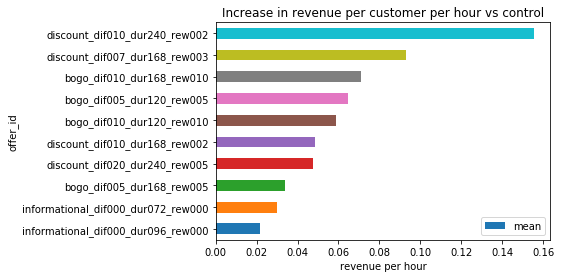

In [50]:
AB_Results.sort_values(by=['mean'],ascending = True).plot.barh(x='offer_id', y='mean')
plt.title('Increase in revenue per customer per hour vs control')
plt.xlabel('revenue per hour')

Finally, I conducted a paired z test on the bootstrapped means because I was trying to see if some were not different from others (for example if two similar offers gave similar outcomes then the one that cost less should be used).  However, due to the large sampling size all offer bootstrapped means are different from one another.  I show the results below for two similar offers (averages of 0.0711 vs 0.0644) and get an overall z test well above the 1.96 for a 95% confidence interval (actual z value = 32.5).

Therefore, the z test isn't needed and all mean differences are different from one another above.  Therefore the recommendation would be 

In [51]:
def z_testAB(offer1, offer2):
    mu1 = AB_Results[AB_Results['offer_id']==offer1].reset_index().at[0,'mean']
    mu2 = AB_Results[AB_Results['offer_id']==offer2].reset_index().at[0,'mean']
    sd1 = AB_Results[AB_Results['offer_id']==offer1].reset_index().at[0,'st_dev']
    sd2 = AB_Results[AB_Results['offer_id']==offer2].reset_index().at[0,'st_dev']
    n1 = AB_Results[AB_Results['offer_id']==offer1].reset_index().at[0,'sample_size']
    n2 = AB_Results[AB_Results['offer_id']==offer2].reset_index().at[0,'sample_size']
    
    z_score = (max(mu1,mu2) - min(mu1,mu2))/np.sqrt(sd1**2/n1 + sd2**2/n2)
    return z_score

In [52]:
z_testAB('bogo_dif010_dur168_rew010','bogo_dif005_dur120_rew005')

31.338349937539803